In [1]:
import cv2
import matplotlib
import matplotlib.pyplot as plt
import mediapipe as mp
import numpy as np

mp_drawing = mp.solutions.drawing_utils
mp_face_mesh = mp.solutions.face_mesh

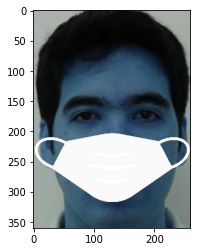

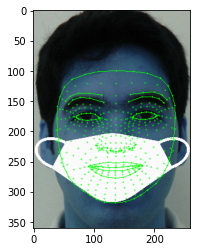

In [2]:
#Test Mask
image = cv2.imread('dataset/9a.jpg', cv2.IMREAD_COLOR)
maskimage = cv2.imread('mask2.png', cv2.IMREAD_UNCHANGED)
h, w, c = image.shape

for i in range(0,w):
    for j in range(0,h):
        if (maskimage[j,i,3]!=0):
            image[j,i,0] = maskimage[j,i,0]
            image[j,i,1] = maskimage[j,i,1]
            image[j,i,2] = maskimage[j,i,2]
        
plt.imshow(image)
plt.show()

face_mesh = mp_face_mesh.FaceMesh(
    static_image_mode=True,
    max_num_faces=1,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5)

mp_drawing = mp.solutions.drawing_utils 
drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)

results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

annotated_image = image.copy()
for face_landmarks in results.multi_face_landmarks:
    mp_drawing.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks,
        connections=mp_face_mesh.FACE_CONNECTIONS,
        landmark_drawing_spec=drawing_spec,
        connection_drawing_spec=drawing_spec)
plt.imshow(annotated_image)
plt.show()

In [3]:
def wear_mask(image):
    maskimage = cv2.imread('mask2.png', cv2.IMREAD_UNCHANGED)
    h, w, c = image.shape
    for i in range(0,w):
        for j in range(0,h):
            if (maskimage[j,i,3]!=0):
                image[j,i,0] = maskimage[j,i,0]
                image[j,i,1] = maskimage[j,i,1]
                image[j,i,2] = maskimage[j,i,2]
    return image

face_mesh = mp_face_mesh.FaceMesh(
    static_image_mode=True,
    max_num_faces=1,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5)

dataset = None

# Standard Face
path = 'dataset/1a.jpg'
image = cv2.imread(path, cv2.IMREAD_COLOR)
results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

low_bound = results.multi_face_landmarks[0].landmark[10].y
#up_bound = results.multi_face_landmarks[0].landmark[197].y
up_bound = results.multi_face_landmarks[0].landmark[145].y
#up_bound = results.multi_face_landmarks[0].landmark[152].y
subset = [i for i, val in enumerate(results.multi_face_landmarks[0].landmark) if (val.y >= low_bound) and (val.y <= up_bound)]

# Dataset Generation
for pic in range(1, 201):
    for smile in ('a', 'b'):
        path = 'dataset/' + str(pic) + smile + '.jpg'
        image = cv2.imread(path, cv2.IMREAD_COLOR)
        #image = wear_mask(image)
        results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        filtered = [results.multi_face_landmarks[0].landmark[i] for i in subset]
        row = np.array([i.x for i in filtered] + [i.y for i in filtered] + [i.z for i in filtered] + list(smile))
        
        if dataset is None:
            dataset = row
        else:
            dataset = np.vstack((dataset, row))
print(dataset.shape)

(400, 367)


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

x = dataset[:, :-1]
x = x.astype(np.float)
y = dataset[:, -1]
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 0.4, random_state = 0)

In [5]:
# SVM
from sklearn.svm import SVC
svm = SVC()
pipe_svm = Pipeline([('scale', StandardScaler()), 
                     ('svm', svm)])

param_grid_svm = dict(svm__C=np.arange(1, 50, 1).tolist(),
                      svm__gamma=[1e-2, 1e-3, 5e-4, 1e-4, 5e-5, 1e-5])
searchsvm = GridSearchCV(pipe_svm, param_grid_svm, cv=10, n_jobs=-1)
searchsvm.fit(xTrain, yTrain)
print("Best parameter (CV score=%0.3f):" % searchsvm.best_score_)
print(searchsvm.best_params_)

from joblib import dump
dump(searchsvm, 'svm_mask.joblib') 

Best parameter (CV score=0.942):
{'svm__C': 42, 'svm__gamma': 0.0001}


['svm_mask.joblib']

In [6]:
# Testing Results
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

print(accuracy_score(searchsvm.predict(xTest), yTest))
print(confusion_matrix(yTest, searchsvm.predict(xTest)))

0.95
[[89  2]
 [ 6 63]]


In [ ]:
# Real-Time 

from joblib import load
import cv2
import matplotlib
import matplotlib.pyplot as plt
import mediapipe as mp
import numpy as np
import time

def crop_center(img,cropx,cropy):
    y,x,c = img.shape
    startx = x//2 - cropx//2
    starty = y//2 - cropy//2    
    return img[starty:starty+cropy, startx:startx+cropx, :]

mp_drawing = mp.solutions.drawing_utils
mp_face_mesh = mp.solutions.face_mesh

printsmile = True
lastoutput = ''

searchsvm = load('svm_mask.joblib') 

face_mesh = mp_face_mesh.FaceMesh(
    min_detection_confidence=0.5, min_tracking_confidence=0.5)
drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)

# Standard Face
path = 'dataset/1a.jpg'
image = cv2.imread(path, cv2.IMREAD_COLOR)
results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

low_bound = results.multi_face_landmarks[0].landmark[10].y
up_bound = results.multi_face_landmarks[0].landmark[145].y
subset = [i for i, val in enumerate(results.multi_face_landmarks[0].landmark) if (val.y >= low_bound) and (val.y <= up_bound)]

cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 360)
while cap.isOpened():
    success, image = cap.read()
    image = crop_center(image, 260, 360)
    image = cv2.cvtColor(cv2.flip(image, 1), cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = face_mesh.process(image)

    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
    if results.multi_face_landmarks:
        mp_drawing.draw_landmarks(
            image=image,
            landmark_list=results.multi_face_landmarks[0],
            #connections=mp_face_mesh.FACE_CONNECTIONS,
            landmark_drawing_spec=drawing_spec,
            connection_drawing_spec=drawing_spec)
        if printsmile == True:
            filtered = [results.multi_face_landmarks[0].landmark[i] for i in subset]
            row = np.array([i.x for i in filtered] + [i.y for i in filtered] + [i.z for i in filtered])
            if searchsvm.predict([row]) == 'a':
                cv2.putText(image,'Not Smile', (20,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
            else:
                cv2.putText(image,'Smile', (20,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
        cv2.imshow('R U Smiling', image)
        if cv2.waitKey(5) & 0xFF == 27:
            break
    else:
        cv2.putText(image,'Face Not Detected', (20,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
        cv2.imshow('R U Smiling', image)
    #time.sleep(1)
                
face_mesh.close()
cap.release()